# Bayes' law

Use Bayes’ law to calculate the probability of getting a data science job if you’ve gotten an interview for the job. This could be written P(get the DS job | interview). You’ll have to use Bayesian probability methods (your intuition or beliefs) to assign values to the different components of Bayes’ law.

## Solution

`P(get job | interview) = P(get job) * P(interview | get job) / P(interview)`

`P(interview) = P(get job) * P(interview | get job) + P(!get job) * P(interview | !get job)`

I'm going to assign values based on intuition here. Usually the probability of getting a job from applying is very low, around 1%. This is based on experience and reading about how most people apply to 100 jobs in order to get 1 job. Next, I will say P(interview | get job) is 99%. Almost no one will hire someone they didn't interview. Last, P(interview | !get job) will be set to 10%. In my experience, we might interview 10% of candidates, and only one gets the job. Plugging these numbers in:

`P(interview) = 0.01*0.99 + 0.99*0.1 = 0.1089`
`P(get job | interview) = 0.01 * 0.99 / 0.1089 = 0.091`

So we find that we have about a 9% chance of getting the job given we had an interview. Interestingly, this lines up well with the 1/10 (roughly) interviewed candidates that I estimated would get any given job.

# MISO distributions

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

In [8]:
df = pd.read_csv('data/miso_wind_data.csv')
df.head()

,Market Day,Hour Ending,MWh
0,1/1/2020,1,12161.42
1,1/1/2020,2,13090.65
2,1/1/2020,3,13597.16
3,1/1/2020,4,13638.77
4,1/1/2020,5,13320.79


In [14]:
df.describe()

,Hour Ending
count,8784.000000
mean,12.500000
std,6.922581
min,1.000000
25%,6.750000
50%,12.500000
75%,18.250000
max,24.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Market Day   8784 non-null   object
 1   Hour Ending  8784 non-null   int64 
 2   MWh          8784 non-null   object
dtypes: int64(1), object(2)
memory usage: 206.0+ KB


In [17]:
df['MWh'] = df['MWh'].astype('float')

<AxesSubplot:xlabel='MWh', ylabel='Count'>

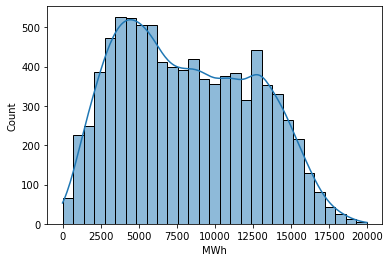

In [18]:
sns.histplot(df['MWh'], kde=True)

Recall from the chapter that Weibull can often be used to model windspeed-related data. The distribution doesn't look perfect here, we should probably break it up by season. But we will still try fitting with a Weibull and see how it compares.

In [29]:
# this gives us c, loc, and scale
wb_fit = weibull_min.fit(df['MWh'])
wb_fit

(0.1041568091512397, -33.580000000000005, 3.3041852511183105)

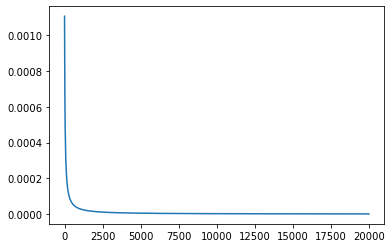

In [78]:
wb = weibull_min(c=wb_fit[0], loc=wb_fit[1], scale=wb_fit[2])
x = np.linspace(0, 20000, 1000)
plt.plot(x, wb.pdf(x))

That doesn't look right at all. We need to give starting values for our parameters so it has a better chance of fitting. Let's play around with the parameters to figure out what it should be closer to. The key here was the scale parameter - it needs to be on the order of the spread of the data.

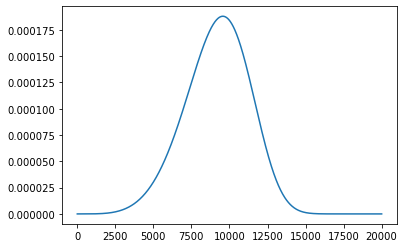

In [79]:
wb = weibull_min(c=5, loc=0, scale=10000)
plt.plot(x, wb.pdf(x))

In [48]:
weibull_min.fit?

In [74]:
params = weibull_min.fit(df['MWh'].values, scale=20000)
params

(2.0806616070968973, -448.4293623193927, 9704.828895457018)

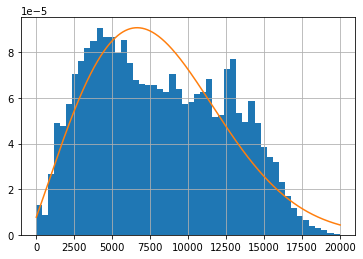

In [92]:
wb = weibull_min(c=params[0], loc=params[1], scale=params[2])
f, ax = plt.subplots()
# the density=1 argument makes the integral of the histogram equal 1, so it's on the same scale as the PDF
df['MWh'].hist(density=1, ax=ax, bins=50)
ax.plot(x, wb.pdf(x))

Hey, not a bad fit! It looks like it is like a bi-modal distribution, composed of two or three Weibulls from the different seasons. We chose the Weibull, again, because it's known to represent this sort of data. Also, we can eyeball the histogram and pick a distribution that seems to fit.

In [105]:
means = []
for i in range(10000):
    sample = np.random.choice(df['MWh'], 1000, replace=True)
    means.append(sample.mean())

<AxesSubplot:ylabel='Count'>

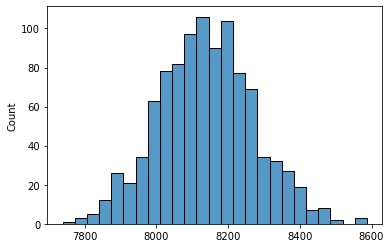

In [104]:
sns.histplot(means)

Yes, looks like it's approaching a normal distribution.